In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from qdax import environments
import jax

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output


from utils.network import Sequential
import random

from IPython.display import HTML
from brax.v1.io import html

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [3]:
from brax.io import torch as io_torch
import random

class TorchWrapper:
    def __init__(self, env, num_envs):
        
        self.env = env
        self.num_envs = num_envs
        self.state_dim = env.observation_size
        self.action_dim = env.action_size
        
        
        self.reset_fn = jax.jit(jax.vmap(env.reset))
        self.step_fn = jax.jit(jax.vmap(env.step))
        
        # self.reset_fn = jax.vmap(env.reset)
        # self.step_fn = jax.vmap(env.step)
        
    
    def reset(self, seed=None):
        
        random_key = jax.random.PRNGKey(random.randint(0, 99999999))
        keys = jax.random.split(random_key, num=self.num_envs)
        # random_key, subkey = jax.random.split(random_key)
        if seed is not None:
            keys = jax.random.PRNGKey(seed)
            keys = jax.numpy.expand_dims(keys, axis=0)
            keys = jax.numpy.repeat(keys, repeats=self.num_envs, axis=0)
        # print(keys)
        state = self.reset_fn(keys)
        self.state = state
        return io_torch.jax_to_torch(state.obs)
    
    def step(self, action: torch.Tensor):
        
        action = io_torch.torch_to_jax(action)
        next_state = self.step_fn(self.state, action)
        observation, reward, done, state_descriptor = next_state.obs, next_state.reward, next_state.done, next_state.info['state_descriptor']
        # print('jax:', reward.min(), reward.max())
        observation = io_torch.jax_to_torch(observation)
        reward = io_torch.jax_to_torch(reward)
        # print('torch:', reward.min(), reward.max())
        done = io_torch.jax_to_torch(done)
        # print('jax:', state_descriptor)
        state_descriptor = io_torch.jax_to_torch(state_descriptor)
        # print('torch:', state_descriptor)
        
        self.state = next_state
        
        return observation, reward, done, {'state_descriptor': state_descriptor}
        

In [4]:
# Hyperparameters
max_timesteps = 3000
n_epochs = 10
learning_rate = 0.0003
gamma = 0.99
eps_clip = 0.2
K_epochs = 4
action_std = 0.5
batch_size = 64
update_timestep = 2000

beta = 0.0

BEHAVIOR_DIM = 10

env_name = 'halfcheetah_uni'
reward_offset = environments.reward_offset[env_name]
reward_offset

9.231

In [5]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns

In [6]:
class ConditionedActorCriticContinuous(nn.Module):
    def __init__(self, descriptor_dim, state_dim, action_dim, actor_hidden_layers, critic_hidden_layers, action_std):
        super(ConditionedActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(nn.Linear(input_dim, hidden_dim))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(nn.Linear(input_dim, action_dim))
        # actor_layers.append(nn.Tanh())
        self.actor = nn.Sequential(*actor_layers)
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, x, action=None):
        # print(f"{alpha.shape=}")

        action_mean = self.actor(x)
        cov_matrix = torch.exp(self.action_var)
        dist = Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
        
        return action, action_mean, log_p, value, dist.entropy()

In [7]:
class Linear(nn.Module):
    def __init__(self, n_anchors, in_channels, out_channels, bias = True, same_init = False):
        super().__init__()
        self.n_anchors = n_anchors
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_bias = bias

        if same_init:
            anchor = nn.Linear(in_channels,out_channels,bias=self.is_bias)
            anchors = [copy.deepcopy(anchor) for _ in range(n_anchors)]
        else:
            anchors = [nn.Linear(in_channels,out_channels,bias=self.is_bias) for _ in range(n_anchors)]
        self.anchors = nn.ModuleList(anchors)

    def forward(self, x, alpha):
        
        xs = [anchor(x) for anchor in self.anchors]
        xs = torch.stack(xs,dim=-1)

        # alpha = torch.stack([alpha] * self.out_channels, dim=-2)
        # print(xs.shape, alpha.shape)
        alpha = alpha.unsqueeze(1).repeat(1, self.out_channels, 1)
        # print(xs.shape, alpha.shape)
        # print(xs.shape, alpha.shape, self.out_channels)
        # [8, 256, 2] [256, 2]
        xs = (xs * alpha).sum(-1)
        return xs
    
    
    
class Sequential(nn.Sequential):
    def __init__(self,*args):
        super().__init__(*args)

    def forward(self, input, t):
        # print(input.shape, t.shape)
        # print(input.shape, t.shape)
        for module in self:
            input = module(input,t) if isinstance(module,Linear) else module(input)
        return input


class MetaAlphaModel(nn.Module):
    def __init__(self, anchors, state_dim, action_dim, actor_hidden_layers, critic_hidden_layers, action_std):
        super(MetaAlphaModel, self).__init__()
        
        n_anchors = len(anchors)
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(Linear(n_anchors, input_dim, hidden_dim, same_init=False, bias=False))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(Linear(n_anchors, input_dim, action_dim, same_init=False, bias=False))
        actor_layers.append(nn.Tanh())
        self.actor = Sequential(*actor_layers)
        self.n_anchors = n_anchors
        
        
        for agent_id, agent in enumerate(anchors):
            agent_parameters = dict(agent.named_parameters())
            for meta_name, meta_p in self.named_parameters():
                prefix, layer, _, anchor_id, w_b = meta_name.split('.')
                if prefix == 'actor' and int(anchor_id) == agent_id:
                    agent_param_name = f"actor.{layer}.{w_b}"
                    meta_p.data.copy_(agent_parameters[agent_param_name].data)
                    
        # self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    # def forward(self, x, alpha, action=None):
    #     action_mean = self.actor(x, alpha)
    #     cov_matrix = torch.exp(self.action_var)
    #     dist = Normal(loc=action_mean, scale=cov_matrix)
    #     if action is None:
    #         action = dist.sample()
    #     log_p = dist.log_prob(action).sum(dim=-1)
    #     return action, action_mean, log_p
    
    def forward(self, x, alpha):
        action = self.actor(x, alpha)                
        return action

In [8]:
class AlphaMapper(nn.Module):
    def __init__(self, in_alpha, n_achors):
        super(AlphaMapper, self).__init__()
        self.fc_mean = nn.Sequential(
            nn.Linear(in_alpha, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, n_achors, bias=False),
            # nn.ReLU(),
            # nn.Linear(32, n_achors),
            # nn.Linear(in_alpha, n_achors, bias=False),
        )
        
        self.critic = nn.Sequential(
            nn.Linear(in_alpha, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            # nn.ReLU(),
            # nn.Linear(32, 1),
            # nn.Linear(in_alpha, 1, bias=False),
        )
        
        self.log_std = nn.Parameter(torch.tensor((0.25,)))

    def forward(self, x, action=None):
        mean = self.fc_mean(x)
        std = torch.exp(self.log_std)
        distribution = torch.distributions.Normal(mean, std)
        if action is None:
            action = distribution.sample()
        log_prob = distribution.log_prob(action).sum(dim=-1)
        entropy = distribution.entropy().sum(dim=-1)
        
        value = self.critic(x)
    
        return action, log_prob, value, entropy
    
    def predict(self, x):
        return self.fc_mean(x)


In [9]:
# x = u.to(device)

# mean = mapper.fc_mean(x)
# std = torch.exp(torch.tensor([-10, -10])).to(device)
# print(std)
# distribution = torch.distributions.Normal(mean, std)
# action = distribution.sample()
# log_prob = distribution.log_prob(action).sum(dim=-1)
# entropy = distribution.entropy().sum(dim=-1)

In [10]:
def get_descriptor(info):
    d1 = np.mean([d1 for (d1, d2) in info])
    d2 = np.mean([d2 for (d1, d2) in info])
    return d1, d2
    # return np.mean(info['bfoot_touch_ground']), np.mean(info['ffoot_touch_ground'])
    
    
def get_descriptors_from_trajectories(data):
    
    num_envs = data['info'].shape[0]
    
    descriptors = []
    for n in range(num_envs):
        env_n_descriptors = []
        trajectory_info = []
        for i in range(len(data['info'][n])):
            # print(i)
            trajectory_info.append(data['info'][n][i])
            
            if data['done'][n][i] == True:
                d1, d2 = get_descriptor(trajectory_info)
                descriptors.append((d1, d2))
        
        # descriptors.append(env_n_descriptors)
        
    return descriptors




def descriptors_to_vectors(descriptors):
    vectors = []
    for (d1, d2) in descriptors:
        vector = [0]*(BEHAVIOR_DIM**2)
        vector[d1*BEHAVIOR_DIM+d2] = 1
        vectors.append(vector)
    return vectors

def descriptors_to_id(descriptors):
    ids = []
    for (d1, d2) in descriptors:
        ids.append(d1*BEHAVIOR_DIM+d2)
    return ids

def descriptors_vec2coord(descriptors):
    d_id = descriptors.argmax(axis=1)
    d1, d2 = d_id // BEHAVIOR_DIM, d_id % BEHAVIOR_DIM
    return torch.concat((d1.unsqueeze(0), d2.unsqueeze(0))).t().float() / BEHAVIOR_DIM

In [11]:
def random_descriptors(n):
    descriptors = torch.zeros((n, BEHAVIOR_DIM**2), dtype=torch.float32)
    for i in range(n):
        descriptors[i, torch.randint(0, BEHAVIOR_DIM**2, size=(1,))] = 1.
    return descriptors

In [12]:
def evaluate(env, model, descriptor):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    trajectory = []
    info = []
    

    while True:
        trajectory.append(state)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            action, mean_action, log_p, state_value, entropy = model(state, descriptor)
        next_state, reward, terminated, truncated, _ = env.step(action[0].cpu().tolist())

        info.append((
            int(5 in env.data.contact.geom2), int(8 in env.data.contact.geom2)
        ))
        
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1
        
        
        if done:
            break
        
    return total_reward, trajectory, info


def get_reward_from_trajectory(info):
    reward_list = []
    real_reward_list = []
    sim_list = []
    acc_reward = 0
    acc_real_reward = 0
    acc_similarity = 0
    for n in range(len(info['reward'])):
        for i in range(len(info['reward'][n])):
            if info['done'][n][i] == True:
                reward_list.append(acc_reward)
                real_reward_list.append(acc_real_reward)
                sim_list.append(acc_similarity)
                acc_reward = 0
                acc_real_reward = 0
                acc_similarity = 0
            
            acc_reward += info['reward'][n][i]
            acc_real_reward += info['real_reward'][n][i]
            acc_similarity += info['similarity'][n][i]

    return np.mean(reward_list), np.mean(real_reward_list), np.mean(sim_list)

In [13]:
def post_process(action):
    # return torch.tanh(action)
    return torch.clip(action, -1, 1)

In [14]:

def collect_trajectories(env: TorchWrapper, env_per_group:int, n_steps, mapper, meta_agent: MetaAlphaModel):
    
    n_groups = env.num_envs // env_per_group
    assert n_groups*env_per_group == env.num_envs
    
    # u = torch.rand((env.num_envs, 1), dtype=torch.float32, device=device) * 2 - 1
    u = torch.linspace(-1, 1, env.num_envs, dtype=torch.float32, device=device).unsqueeze(-1)

    alpha, log_prob, value, _ = mapper(u)
    # print(u.shape, alpha.shape)

    state_descriptors = torch.zeros((env.num_envs, n_steps, 2), dtype=torch.float32)
    real_rewards = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    

    state = env.reset()
    for s in range(n_steps):
        
        state = state.to(device)
        
        with torch.no_grad():
            action = meta_agent(
                state,  
                alpha.reshape(n_groups*env_per_group, meta_agent.n_anchors)
            )

        next_state, reward, done, info_dict = env.step(post_process(action))
        # print(reward.dtype)
        # print(reward)
        
        state = next_state
        state_descriptors[:, s] = info_dict['state_descriptor'].cpu()
        real_rewards[:, s] = reward.cpu()
    
    
    # print(real_rewards.min(), real_rewards.max())
    state_descriptors = state_descriptors.reshape(n_groups, env_per_group, n_steps, 2)
    real_rewards = real_rewards.reshape(n_groups, env_per_group, n_steps)
    real_rewards = real_rewards.sum(-1)

    achieved_descriptors = state_descriptors.mean(axis=-2)
    achieved_descriptors_ids = torch.round(achieved_descriptors[..., 0]*BEHAVIOR_DIM*BEHAVIOR_DIM + achieved_descriptors[..., 1]*BEHAVIOR_DIM)
    
    qd_score = []
    for group in range(n_groups):
        group_desc_ids = achieved_descriptors_ids[group]
        group_rewards = real_rewards[group]
        unique_ids = torch.unique(group_desc_ids)
        
        fitnesses = []
        for id in unique_ids:
            fitnesses.append(group_rewards[group_desc_ids == id].max())    
        qd_score.append(sum(fitnesses))
    qd_score = torch.stack(qd_score)
    # print(qd_score.shape)
    
    
    nb_filled = torch.tensor([len(torch.unique(row)) for row in achieved_descriptors_ids])
    coverage = nb_filled / (BEHAVIOR_DIM**2)
    # reward = coverage
    reward = qd_score
    
    
    reward = reward.unsqueeze(-1).repeat(1, env_per_group)
        

    return (
        u.reshape(-1, 1).detach(), # state
        alpha.detach(), # action
        reward.reshape(-1).detach(), # reward
        log_prob.reshape(-1).detach(), # log prob of the action (alpha)
        value.detach(),
        {'coverage': coverage}
    )

In [15]:
# mapper = AlphaMapper(1, 2).to(device)
# u, alpha, reward, log_prob, value, info = collect_trajectories(env, env_per_group, max_episode_steps, mapper, meta_agent)

In [16]:
def ppo_optimization(mapper, optimizer, u_list, alpha_list, reward_list, log_prob_list, value_list, batch_size=256, eps=0.2):
    
    for _ in range(4):
        for i in range(u_list.shape[0]//batch_size):
            
            u = u_list[batch_size*i:batch_size*(i+1)]
            alpha = alpha_list[batch_size*i:batch_size*(i+1)]
            reward = reward_list[batch_size*i:batch_size*(i+1)]
            log_prob = log_prob_list[batch_size*i:batch_size*(i+1)]
            value = value_list[batch_size*i:batch_size*(i+1)]
                        
            p_old = log_prob.detach()

            new_action, p_new, value_new, entropy = mapper(u, alpha)
            assert (new_action == alpha).all()

            advantage = reward - value
            
            ratio = torch.exp(p_new - p_old)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - eps, 1 + eps) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            value_loss = ((reward - value_new)**2).mean()
            
            
            loss = policy_loss + 0.5*value_loss - 0.0*entropy.mean()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(mapper.parameters(), 0.5)
            optimizer.step()
            
    return value_loss, entropy

In [17]:
def shuffle_tensors(u, alpha, reward, log_prob, value):
    # Generate random shuffle indices
    shuffle_indices = torch.randperm(u.size(0))
    
    # Shuffle all tensors using the same indices
    u = u[shuffle_indices]
    alpha = alpha[shuffle_indices]
    reward = reward[shuffle_indices]
    log_prob = log_prob[shuffle_indices]
    value = value[shuffle_indices]
    
    return u, alpha, reward, log_prob, value

In [18]:
max_episode_steps = 100

num_envs = 2048

base_env = environments.create(env_name="halfcheetah_uni", episode_length=max_episode_steps)
env = TorchWrapper(base_env, num_envs=num_envs)

observation = env.reset()

state_dim = env.env.observation_size
action_dim = env.env.action_size

In [19]:

agent1 = ConditionedActorCriticContinuous(
    BEHAVIOR_DIM**2,
    state_dim,
    action_dim,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)
agent1.load_state_dict(torch.load('./models/d=(0, 0)+run.pt'))

agent2 = ConditionedActorCriticContinuous(
    BEHAVIOR_DIM**2,
    state_dim,
    action_dim,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)
agent2.load_state_dict(torch.load('./models/d=(0.5, 0.5)+run.pt'))



meta_agent = MetaAlphaModel(
    [agent1, agent2],
    state_dim,
    action_dim,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5,
).to(device)

env_per_group = 32


/tmp/ipykernel_6674/3226700299.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent1.load_state_dict(torch.load('./models/d=(0, 0)+run.pt'))
/tmp/ipykernel_6674/3226700

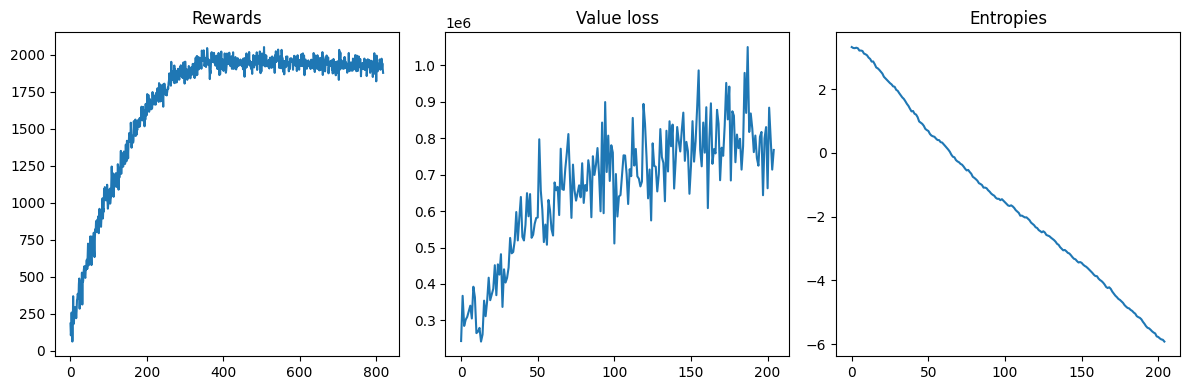

Reward: 1877.66101:  20%|██        | 205/1000 [11:01<42:33,  3.21s/it]

In [20]:
mapper = AlphaMapper(1, 2).to(device)
optimizer = torch.optim.Adam(mapper.parameters(), lr=0.01)


rewards = []
value_losses = []
entropies = []


tqdm_epochs = tqdm(range(1000))
# tqdm_epochs = range(1000)
for epoch in tqdm_epochs:
    
    u_list, alpha_list, reward_list, log_prob_list, value_list = [], [], [], [], []
    
    # u = torch.rand((env.num_envs, 1))
    # u = torch.linspace(0, 1, env.num_envs).unsqueeze(-1)
    for _ in range(4):
        u, alpha, reward, log_prob, value, info = collect_trajectories(env, env_per_group, max_episode_steps, mapper, meta_agent)
        rewards.append(reward.mean().item())
        u_list.append(u)
        alpha_list.append(alpha)
        reward_list.append(reward)
        log_prob_list.append(log_prob)
        value_list.append(value)

    u_list, alpha_list, reward_list, log_prob_list, value_list = torch.concat(u_list), torch.concat(alpha_list), torch.concat(reward_list), torch.concat(log_prob_list), torch.concat(value_list)
    u_list, alpha_list, reward_list, log_prob_list, value_list = u_list.to(device), alpha_list.to(device), reward_list.to(device), log_prob_list.to(device), value_list.to(device)
        
    
    u_list, alpha_list, reward_list, log_prob_list, value_list = shuffle_tensors(u_list, alpha_list, reward_list, log_prob_list, value_list)
    
    value_loss, entropy = ppo_optimization(mapper, optimizer, u_list, alpha_list, reward_list, log_prob_list, value_list, batch_size=256)
    
    # entropies.append(torch.exp(mapper.log_std).item())
    entropies.append(entropy.mean().item())
    
    value_losses.append(value_loss.item())
    tqdm_epochs.set_description(f'Reward: {reward.mean().item():.5f}')
    
    if epoch % 1 == 0:
        clear_output(True)
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].plot(rewards)
        axes[0].set_title('Rewards')
        
        axes[1].plot(value_losses)
        axes[1].set_title('Value loss')
        
        axes[2].plot(entropies)
        axes[2].set_title('Entropies')
        
        plt.tight_layout()
        plt.show()

In [ ]:
reward

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [ ]:
torch.save(mapper.state_dict(), 'models/mapper_2.pt')

---

In [ ]:
def plot_map_elite(eval_reward, eval_state_descriptor, count=False, N=30):

    x1, x2 = 0, 1

    x1_min = 0
    x1_max = 1
    x2_min = 0
    x2_max = 1

    # N = 30

    x1_bins = np.linspace(x1_min, x1_max, N)
    x2_bins = np.linspace(x2_min, x2_max, N)

    map_grid = np.full((N, N), np.nan)


    def get_bin(value, bins):
        return np.digitize(value, bins) - 1


    for reward, descriptor in zip(eval_reward, eval_state_descriptor):
        feature1, feature2 = descriptor[x1], descriptor[x2]
        # f1_bin = get_bin(feature1, x1_bins)
        # f2_bin = get_bin(feature2, x2_bins)
        # print(descriptor, f1_bin, f2_bin)
        
        f1_bin = torch.round(feature1*N).long()
        f2_bin = torch.round(feature2*N).long()
        # print(f1_bin, f2_bin)
        
        f1_bin = min(f1_bin, N-1)
        f2_bin = min(f2_bin, N-1)
        
        # reward = 1
        if np.isnan(map_grid[f1_bin, f2_bin]):
            if not count:
                map_grid[f1_bin][f2_bin] = reward
            else:
                map_grid[f1_bin][f2_bin] = 1
        else:
            if not count:
                map_grid[f1_bin][f2_bin] = max(map_grid[f1_bin][f2_bin], reward)
            else:
                map_grid[f1_bin][f2_bin] += 1


    fig, axs = plt.subplots(1, 1, figsize=(5,5))


    if count:
        cax = axs.matshow(map_grid, cmap="viridis")
    else:
        cax = axs.matshow(map_grid, cmap="viridis", vmin=-100, vmax=1000)
    axs.set_title('DDPG\n(Full oobservation)', loc='center')

    axs.set_xlabel('bfoot touch ground')
    axs.set_ylabel('ffoot touch ground')
    axs.set_xticks(np.linspace(0, N-1, num=11))
    axs.set_xticklabels(np.round(np.linspace(0, 1, num=11), 2))
    axs.set_yticks(np.linspace(0, N-1, num=11))
    axs.set_yticklabels(np.round(np.linspace(0, 1, num=11), 2))
        
    fig.colorbar(cax, ax=axs, orientation='vertical', label='Reward')
    plt.show()
    
    return map_grid

In [ ]:
mapper = AlphaMapper(1, 2).to(device)
mapper.load_state_dict(torch.load('models/mapper_2.pt'))

/tmp/ipykernel_4546/713455943.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mapper.load_state_dict(torch.load('models/mapper_2.pt'))


<All keys matched successfully>

In [ ]:
num_eval_envs = 2000
eval_base_env = environments.create('halfcheetah_uni', episode_length=max_episode_steps)
eval_env = TorchWrapper(eval_base_env, num_envs=num_eval_envs)

In [ ]:
state = eval_env.reset(10)
n_groups = eval_env.num_envs // env_per_group

eval_state_descriptor = []
eval_reward = []

# u = torch.rand((eval_env.num_envs, 1), dtype=torch.float32, device=device) * 2 - 1
u = torch.linspace(-1, 1, num_eval_envs, dtype=torch.float32, device=device).unsqueeze(-1)
# alpha, _, _, _ = mapper(u)
alpha = mapper.predict(u)


for s in tqdm(range(max_episode_steps)):
    state = state.to(device)
    
    # print((state == state[0]).sum())
    # print(torch.isclose(state, state[0]).sum())
    
    with torch.no_grad():
        
        alpha = torch.zeros((eval_env.num_envs, 2), dtype=torch.float32, device=device)
        alpha[:alpha.shape[0]//2, 0] = 1.
        alpha[alpha.shape[0]//2:, 1] = 1.
        # alpha[..., :] = torch.tensor([1, 1.6])
        
        action = meta_agent(
            state,  
            alpha.reshape(eval_env.num_envs, meta_agent.n_anchors)
        )
        # print(torch.isclose(action, action[0]).sum())
        
        
    next_state, reward, done, info_dict = eval_env.step(post_process(action))
    eval_state_descriptor.append(info_dict['state_descriptor'].cpu().unsqueeze(0))
    eval_reward.append(reward)
    
    state = next_state
# eval_state_descriptor  = torch.concat(eval_state_descriptor, dim=0).mean(dim=1).tolist()

u = u.cpu().detach()
alpha = alpha.cpu().detach()

eval_state_descriptor = torch.concat(eval_state_descriptor, dim=0).mean(0)
eval_reward = torch.stack(eval_reward).sum(dim=0)

# eval_state_descriptor

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 261.96it/s]


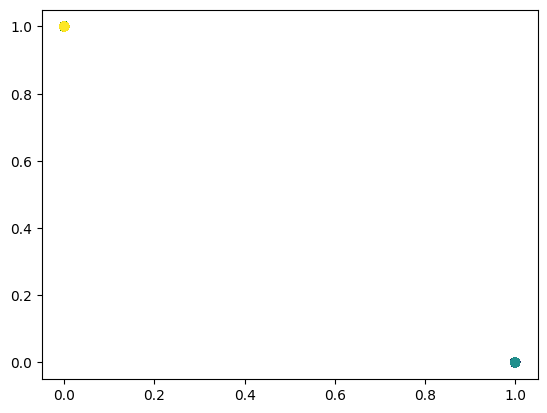

In [ ]:
alpha
plt.scatter(alpha[:, 0], alpha[:, 1], c=u.reshape(-1), vmin=-1, vmax=1)

In [ ]:
# torch.unique(torch.round(eval_state_descriptor[:, 0]*BEHAVIOR_DIM)*BEHAVIOR_DIM + torch.round(eval_state_descriptor[:, 1]*BEHAVIOR_DIM), return_counts=True)
# torch.round(eval_state_descriptor[:, 0]*BEHAVIOR_DIM)*BEHAVIOR_DIM, torch.round(eval_state_descriptor[:, 1]*BEHAVIOR_DIM)

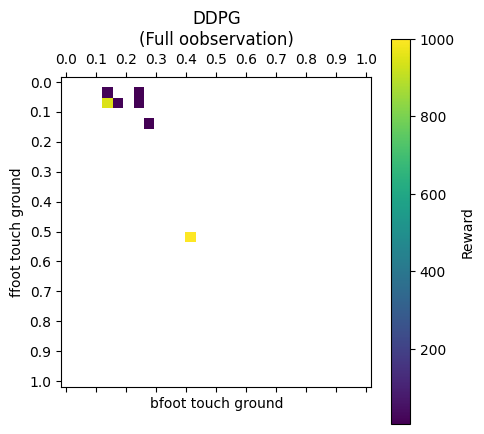

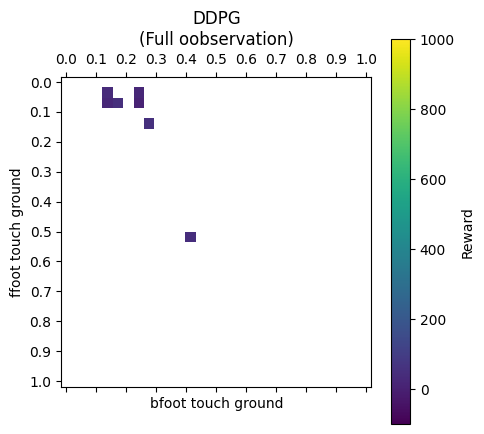

In [ ]:
_ = plot_map_elite(eval_reward, eval_state_descriptor, count=True, N=30)
_ = plot_map_elite(eval_reward, eval_state_descriptor, N=30)

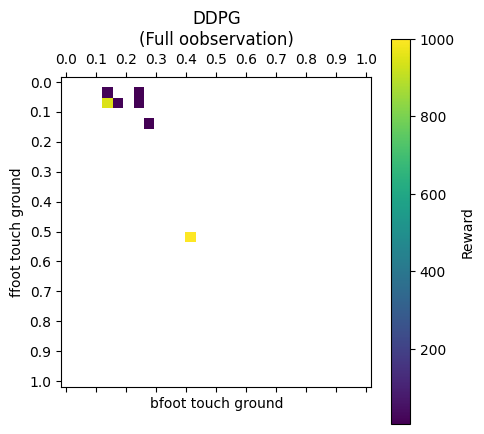

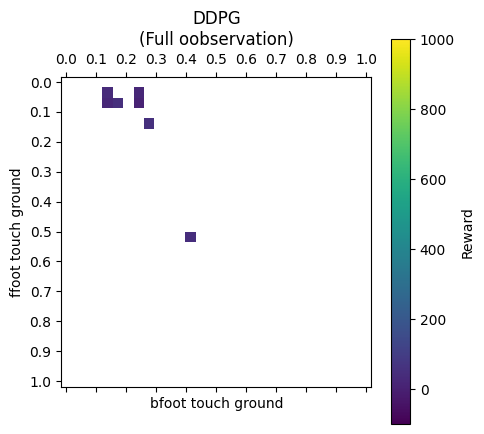

In [ ]:
_ = plot_map_elite(eval_reward, eval_state_descriptor, count=True, N=30)
_ = plot_map_elite(eval_reward, eval_state_descriptor, N=30)